In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
#!pip install albumentations
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [2]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
# import albumentations as T
# import albumentations.augmentations.transforms as T_transforms
# from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [3]:
# Import libraries for tensors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# For fbeta-score
from torchmetrics.functional import fbeta_score

# For nn.Sequential
from collections import OrderedDict

In [4]:
# Import tqdm for progress bar construction
import tqdm

In [5]:
# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:0


In [6]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

# from google.colab import drive
# drive.mount('/content/gdrive')


# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [7]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [8]:
# Modify dataframe for K-Fold Cross Validation (ff1010)
ff1010_csv = pandas.read_csv(FF1010_Path + 'metadata.csv')
ff1010_csv.loc[ff1010_csv['hasbird'] == 0, 'filepath'] = \
    FF1010_Path + 'nocall/' + ff1010_csv.query('hasbird == 0')['filename'] + '.npy'
ff1010_csv.loc[ff1010_csv['hasbird'] == 1, 'filepath'] = \
    FF1010_Path + 'bird/' + ff1010_csv.query('hasbird == 1')['filename'] + '.npy'

ff1010_csv = ff1010_csv.dropna()
ff1010_csv = ff1010_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
ff1010_dataframe = ff1010_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(ff1010_dataframe, ff1010_dataframe['hasbird'])):
    ff1010_dataframe.loc[nth_groups, 'fold'] = int(n)

Model 1 (No-call detector)

In [9]:
# Class for ff1010 dataset
class FF1010(Dataset):
    def __init__(self, dataframe, process='train', labels='hasbird'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.JPEG),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.WEBP),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        
        # Apply transform
        if self.process == 'train':
            source = self.train_transform(Image.fromarray(source))
        elif self.process == 'valid':
            source = self.val_transform(Image.fromarray(source))
        
        return source, torch.tensor(self.labels[idx], dtype=ltype).to(device)
    
    def __len__(self):
        return len(self.dataframe)

This function evaluates model.

In [10]:
def evaluate_model(loader, model, beta):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)
            # In binary classification, it should be (batch size, 2) sized tensor

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.nll_loss(F.log_softmax(scores, dim=-1), y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)

        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

Let's train with model 1.

In [11]:
# Print period for accuracy.
print_period = 12

# Hyper-parameters for training 
ff1010_batch = 32
ff1010_epoch = 10

# Learning Rate.
learning_rate_1 = 0.001

# L2 Regularization Hyperparamter
weight_decay_1 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 1.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 2.
# TODO: I'm curious about the output of the model: would output be the float number
#       between 0 and 1? If not, we need to add sigmoid or softmax function at the end.
model_1 = nn.Sequential(OrderedDict([
        ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
        ("relu", nn.ReLU().to(device)),
        ("linear", nn.Linear(1000, 2, bias=True).to(device)),
        ("softmax", nn.Softmax(dim=-1))
]))

print(model_1)

def train_model(model, train_loader, val_loader, optimizer, beta=beta, epoch=ff1010_epoch):
    val_losses = []
    train_losses = []
    epoch_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    for e in range(epoch):
        print(f"Training model 1, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.nll_loss(F.log_softmax(scores, dim=-1), y) # Log loss for our project.
            epoch_losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # every print_period, evaluate on val_loader.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        epoch_losses = [t.double() for t in epoch_losses]
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Sequential(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [12]:
# from time import sleep

# Train loop for nocall detector
def nocall_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = FF1010(train_dataframe, process='train', labels='hasbird')
    val_data = FF1010(val_dataframe, process='valid', labels='hasbird')
    test_data = FF1010(test_dataframe, process='valid', labels='hasbird')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=ff1010_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
    # Test for loaders
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate_1, momentum=0.5, weight_decay=weight_decay_1)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate_1, weight_decay=weight_decay_1)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [13]:
# Train, Validate and Test for nocall detector
def nocall(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = nocall_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [14]:
cur_model = nn.Sequential(OrderedDict([
    ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
    ("relu", nn.ReLU().to(device)),
    ("linear", nn.Linear(1000, 2, bias=True).to(device)),
    ("softmax", nn.Softmax(dim=-1))
]))
val_losses, train_losses, log_scores, fbeta_scores, test_scores = nocall(cur_model, ff1010_dataframe, 1, 0)

for i in range(2, 5):
    cur_model = nn.Sequential(OrderedDict([
        ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
        ("relu", nn.ReLU().to(device)),
        ("linear", nn.Linear(1000, 2, bias=True).to(device)),
        ("softmax", nn.Softmax(dim=-1))
    ]))
    cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, ff1010_dataframe, i, 0)
    val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
    train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
    log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
    fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
    for j in range(len(test_scores)):
        test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Test set : 0, Validation set : 1
Training model 1, epoch 1


  1%|▌                                                                                 | 1/144 [00:03<08:03,  3.38s/it]

Iteration 0, loss = 0.7428


  9%|███████▎                                                                         | 13/144 [00:07<00:52,  2.50it/s]

Iteration 12, loss = 0.5398


 17%|██████████████                                                                   | 25/144 [00:10<00:45,  2.62it/s]

Iteration 24, loss = 0.6131


 26%|████████████████████▊                                                            | 37/144 [00:14<00:41,  2.59it/s]

Iteration 36, loss = 0.4508


 34%|███████████████████████████▌                                                     | 49/144 [00:18<00:36,  2.62it/s]

Iteration 48, loss = 0.6013


 42%|██████████████████████████████████▎                                              | 61/144 [00:21<00:31,  2.62it/s]

Iteration 60, loss = 0.5995


 51%|█████████████████████████████████████████                                        | 73/144 [00:25<00:27,  2.60it/s]

Iteration 72, loss = 0.5584


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:29<00:22,  2.58it/s]

Iteration 84, loss = 0.5104


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:33<00:19,  2.41it/s]

Iteration 96, loss = 0.5766


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:37<00:14,  2.49it/s]

Iteration 108, loss = 0.6348


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:41<00:09,  2.51it/s]

Iteration 120, loss = 0.4491


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:45<00:04,  2.54it/s]

Iteration 132, loss = 0.5961


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:48<00:00,  2.98it/s]


Checking accuracy score on validation set.


C:\Users\youngrae\AppData\Local\Temp/ipykernel_7404/9450484.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))



Accuracy: 1233 / 1538 correct (80.17)
Log Loss score:	0.51
Fbeta-score (beta=1): 	0.80
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:00<00:46,  3.08it/s]

Iteration 0, loss = 0.5228


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.62it/s]

Iteration 12, loss = 0.5151


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.64it/s]

Iteration 24, loss = 0.4298


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.59it/s]

Iteration 36, loss = 0.4910


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.63it/s]

Iteration 48, loss = 0.6459


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.60it/s]

Iteration 60, loss = 0.5178


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.59it/s]

Iteration 72, loss = 0.4919


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:23,  2.48it/s]

Iteration 84, loss = 0.4605


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.58it/s]

Iteration 96, loss = 0.4630


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.61it/s]

Iteration 108, loss = 0.4308


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.63it/s]

Iteration 120, loss = 0.4018


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.57it/s]

Iteration 132, loss = 0.5564


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.21it/s]


Checking accuracy score on validation set.

Accuracy: 1302 / 1538 correct (84.66)
Log Loss score:	0.46
Fbeta-score (beta=1): 	0.85
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.17it/s]

Iteration 0, loss = 0.4928


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.64it/s]

Iteration 12, loss = 0.4495


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.63it/s]

Iteration 24, loss = 0.4533


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.64it/s]

Iteration 36, loss = 0.4543


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.63it/s]

Iteration 48, loss = 0.3751


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.64it/s]

Iteration 60, loss = 0.3842


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.62it/s]

Iteration 72, loss = 0.4195


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.60it/s]

Iteration 84, loss = 0.3786


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.63it/s]

Iteration 96, loss = 0.3684


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.61it/s]

Iteration 108, loss = 0.4106


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.63it/s]

Iteration 120, loss = 0.3701


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.62it/s]

Iteration 132, loss = 0.3874


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.26it/s]


Checking accuracy score on validation set.

Accuracy: 1343 / 1538 correct (87.32)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.14it/s]

Iteration 0, loss = 0.3770


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.64it/s]

Iteration 12, loss = 0.4540


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.60it/s]

Iteration 24, loss = 0.4725


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.62it/s]

Iteration 36, loss = 0.4191


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.63it/s]

Iteration 48, loss = 0.5024


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.63it/s]

Iteration 60, loss = 0.3596


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.63it/s]

Iteration 72, loss = 0.4890


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.64it/s]

Iteration 84, loss = 0.3715


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:29<00:17,  2.62it/s]

Iteration 96, loss = 0.4931


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.61it/s]

Iteration 108, loss = 0.4261


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.63it/s]

Iteration 120, loss = 0.4751


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.58it/s]

Iteration 132, loss = 0.3919


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.24it/s]


Checking accuracy score on validation set.

Accuracy: 1350 / 1538 correct (87.78)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:00<00:47,  3.03it/s]

Iteration 0, loss = 0.4582


  9%|███████▎                                                                         | 13/144 [00:04<00:51,  2.55it/s]

Iteration 12, loss = 0.4940


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.62it/s]

Iteration 24, loss = 0.4418


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.63it/s]

Iteration 36, loss = 0.4099


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.63it/s]

Iteration 48, loss = 0.3784


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.59it/s]

Iteration 60, loss = 0.3552


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.61it/s]

Iteration 72, loss = 0.4847


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.59it/s]

Iteration 84, loss = 0.4234


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.60it/s]

Iteration 96, loss = 0.3947


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.61it/s]

Iteration 108, loss = 0.4139


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.63it/s]

Iteration 120, loss = 0.4423


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.54it/s]

Iteration 132, loss = 0.4199


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.21it/s]


Checking accuracy score on validation set.

Accuracy: 1360 / 1538 correct (88.43)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:00<00:47,  3.04it/s]

Iteration 0, loss = 0.5249


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.58it/s]

Iteration 12, loss = 0.4093


 17%|██████████████                                                                   | 25/144 [00:07<00:47,  2.50it/s]

Iteration 24, loss = 0.3760


 26%|████████████████████▊                                                            | 37/144 [00:11<00:42,  2.51it/s]

Iteration 36, loss = 0.4228


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:37,  2.56it/s]

Iteration 48, loss = 0.4646


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.59it/s]

Iteration 60, loss = 0.4267


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:27,  2.63it/s]

Iteration 72, loss = 0.4353


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.63it/s]

Iteration 84, loss = 0.3772


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.60it/s]

Iteration 96, loss = 0.3447


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.63it/s]

Iteration 108, loss = 0.4301


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.62it/s]

Iteration 120, loss = 0.3761


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.60it/s]

Iteration 132, loss = 0.4181


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.20it/s]


Checking accuracy score on validation set.

Accuracy: 1331 / 1538 correct (86.54)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.18it/s]

Iteration 0, loss = 0.3624


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.62it/s]

Iteration 12, loss = 0.4642


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.58it/s]

Iteration 24, loss = 0.3798


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.62it/s]

Iteration 36, loss = 0.4058


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.62it/s]

Iteration 48, loss = 0.4411


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.62it/s]

Iteration 60, loss = 0.4381


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.59it/s]

Iteration 72, loss = 0.3754


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.60it/s]

Iteration 84, loss = 0.4165


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.62it/s]

Iteration 96, loss = 0.3854


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.60it/s]

Iteration 108, loss = 0.4078


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.62it/s]

Iteration 120, loss = 0.5037


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.63it/s]

Iteration 132, loss = 0.4153


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.23it/s]


Checking accuracy score on validation set.

Accuracy: 1367 / 1538 correct (88.88)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 8


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.15it/s]

Iteration 0, loss = 0.3916


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.59it/s]

Iteration 12, loss = 0.3449


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.61it/s]

Iteration 24, loss = 0.5070


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.62it/s]

Iteration 36, loss = 0.4281


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.62it/s]

Iteration 48, loss = 0.4165


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:32,  2.57it/s]

Iteration 60, loss = 0.3630


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.63it/s]

Iteration 72, loss = 0.4281


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.57it/s]

Iteration 84, loss = 0.3764


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.62it/s]

Iteration 96, loss = 0.4408


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.60it/s]

Iteration 108, loss = 0.4637


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.57it/s]

Iteration 120, loss = 0.4291


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.62it/s]

Iteration 132, loss = 0.4214


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.22it/s]


Checking accuracy score on validation set.

Accuracy: 1338 / 1538 correct (87.00)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 9


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.13it/s]

Iteration 0, loss = 0.3825


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.61it/s]

Iteration 12, loss = 0.3560


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.62it/s]

Iteration 24, loss = 0.3762


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.58it/s]

Iteration 36, loss = 0.4203


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.61it/s]

Iteration 48, loss = 0.3757


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.61it/s]

Iteration 60, loss = 0.4801


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.58it/s]

Iteration 72, loss = 0.4062


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.58it/s]

Iteration 84, loss = 0.3769


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.60it/s]

Iteration 96, loss = 0.3766


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.60it/s]

Iteration 108, loss = 0.4057


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:09,  2.54it/s]

Iteration 120, loss = 0.5351


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.52it/s]

Iteration 132, loss = 0.4661


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.19it/s]


Checking accuracy score on validation set.

Accuracy: 1352 / 1538 correct (87.91)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 10


  1%|▌                                                                                 | 1/144 [00:00<00:48,  2.98it/s]

Iteration 0, loss = 0.3754


  9%|███████▎                                                                         | 13/144 [00:04<00:52,  2.48it/s]

Iteration 12, loss = 0.4103


 17%|██████████████                                                                   | 25/144 [00:08<00:47,  2.53it/s]

Iteration 24, loss = 0.4771


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.57it/s]

Iteration 36, loss = 0.3761


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.58it/s]

Iteration 48, loss = 0.3833


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:33,  2.49it/s]

Iteration 60, loss = 0.4297


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:27,  2.58it/s]

Iteration 72, loss = 0.4744


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:27<00:22,  2.60it/s]

Iteration 84, loss = 0.4515


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.58it/s]

Iteration 96, loss = 0.4187


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.59it/s]

Iteration 108, loss = 0.3449


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.60it/s]

Iteration 120, loss = 0.3236


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:42<00:04,  2.60it/s]

Iteration 132, loss = 0.4797


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.17it/s]


Checking accuracy score on validation set.

Accuracy: 1370 / 1538 correct (89.08)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Checking accuracy score on validation set.

Accuracy: 1358 / 1538 correct (88.30)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88


Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Test set : 0, Validation set : 2
Training model 1, epoch 1


  1%|▌                                                                                 | 1/144 [00:00<00:50,  2.84it/s]

Iteration 0, loss = 0.8415


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.58it/s]

Iteration 12, loss = 0.5335


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.62it/s]

Iteration 24, loss = 0.5764


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.57it/s]

Iteration 36, loss = 0.4612


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:37,  2.56it/s]

Iteration 48, loss = 0.5065


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.61it/s]

Iteration 60, loss = 0.4939


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.61it/s]

Iteration 72, loss = 0.5250


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.61it/s]

Iteration 84, loss = 0.5301


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.62it/s]

Iteration 96, loss = 0.5129


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.57it/s]

Iteration 108, loss = 0.5543


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.60it/s]

Iteration 120, loss = 0.4969


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.60it/s]

Iteration 132, loss = 0.4522


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.21it/s]


Checking accuracy score on validation set.

Accuracy: 1264 / 1538 correct (82.18)
Log Loss score:	0.50
Fbeta-score (beta=1): 	0.82
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.18it/s]

Iteration 0, loss = 0.4799


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.64it/s]

Iteration 12, loss = 0.5668


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.61it/s]

Iteration 24, loss = 0.5156


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.65it/s]

Iteration 36, loss = 0.4805


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:35,  2.65it/s]

Iteration 48, loss = 0.4261


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.60it/s]

Iteration 60, loss = 0.3925


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.58it/s]

Iteration 72, loss = 0.4038


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.61it/s]

Iteration 84, loss = 0.4324


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.60it/s]

Iteration 96, loss = 0.4388


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.63it/s]

Iteration 108, loss = 0.5451


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.64it/s]

Iteration 120, loss = 0.4177


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.64it/s]

Iteration 132, loss = 0.5504


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.25it/s]


Checking accuracy score on validation set.

Accuracy: 1319 / 1538 correct (85.76)
Log Loss score:	0.45
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.24it/s]

Iteration 0, loss = 0.3911


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.57it/s]

Iteration 12, loss = 0.4152


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.60it/s]

Iteration 24, loss = 0.4832


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.62it/s]

Iteration 36, loss = 0.4259


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.63it/s]

Iteration 48, loss = 0.3544


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.61it/s]

Iteration 60, loss = 0.4724


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.64it/s]

Iteration 72, loss = 0.3484


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.63it/s]

Iteration 84, loss = 0.4104


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.63it/s]

Iteration 96, loss = 0.5140


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.62it/s]

Iteration 108, loss = 0.4227


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.60it/s]

Iteration 120, loss = 0.4180


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.60it/s]

Iteration 132, loss = 0.4772


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.24it/s]


Checking accuracy score on validation set.

Accuracy: 1320 / 1538 correct (85.83)
Log Loss score:	0.45
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.18it/s]

Iteration 0, loss = 0.3667


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.63it/s]

Iteration 12, loss = 0.4555


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.58it/s]

Iteration 24, loss = 0.4213


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.61it/s]

Iteration 36, loss = 0.5064


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.58it/s]

Iteration 48, loss = 0.4403


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.64it/s]

Iteration 60, loss = 0.4262


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.58it/s]

Iteration 72, loss = 0.4998


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.59it/s]

Iteration 84, loss = 0.4155


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.59it/s]

Iteration 96, loss = 0.4590


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.61it/s]

Iteration 108, loss = 0.3780


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.62it/s]

Iteration 120, loss = 0.3843


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.63it/s]

Iteration 132, loss = 0.4389


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.23it/s]


Checking accuracy score on validation set.

Accuracy: 1340 / 1538 correct (87.13)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.18it/s]

Iteration 0, loss = 0.5324


  9%|███████▎                                                                         | 13/144 [00:04<00:51,  2.57it/s]

Iteration 12, loss = 0.4079


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.59it/s]

Iteration 24, loss = 0.3230


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.57it/s]

Iteration 36, loss = 0.4080


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.60it/s]

Iteration 48, loss = 0.4611


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.62it/s]

Iteration 60, loss = 0.4258


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.60it/s]

Iteration 72, loss = 0.4079


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.62it/s]

Iteration 84, loss = 0.4141


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.57it/s]

Iteration 96, loss = 0.4672


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.58it/s]

Iteration 108, loss = 0.6412


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.62it/s]

Iteration 120, loss = 0.3690


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.53it/s]

Iteration 132, loss = 0.4416


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.20it/s]


Checking accuracy score on validation set.

Accuracy: 1332 / 1538 correct (86.61)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:00<00:47,  3.04it/s]

Iteration 0, loss = 0.3514


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.60it/s]

Iteration 12, loss = 0.4637


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.57it/s]

Iteration 24, loss = 0.4078


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.56it/s]

Iteration 36, loss = 0.4139


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:37,  2.56it/s]

Iteration 48, loss = 0.3249


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.62it/s]

Iteration 60, loss = 0.4047


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:27,  2.58it/s]

Iteration 72, loss = 0.3279


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.59it/s]

Iteration 84, loss = 0.4546


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.58it/s]

Iteration 96, loss = 0.4097


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.61it/s]

Iteration 108, loss = 0.4200


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.62it/s]

Iteration 120, loss = 0.4325


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.58it/s]

Iteration 132, loss = 0.4249


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.20it/s]


Checking accuracy score on validation set.

Accuracy: 1258 / 1538 correct (81.79)
Log Loss score:	0.49
Fbeta-score (beta=1): 	0.82
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.17it/s]

Iteration 0, loss = 0.4922


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.59it/s]

Iteration 12, loss = 0.3708


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.58it/s]

Iteration 24, loss = 0.4554


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.59it/s]

Iteration 36, loss = 0.3746


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.57it/s]

Iteration 48, loss = 0.4074


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.61it/s]

Iteration 60, loss = 0.3761


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.61it/s]

Iteration 72, loss = 0.3483


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.57it/s]

Iteration 84, loss = 0.3862


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.57it/s]

Iteration 96, loss = 0.3696


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.60it/s]

Iteration 108, loss = 0.3651


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.62it/s]

Iteration 120, loss = 0.3847


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.58it/s]

Iteration 132, loss = 0.3947


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.20it/s]


Checking accuracy score on validation set.

Accuracy: 1314 / 1538 correct (85.44)
Log Loss score:	0.45
Fbeta-score (beta=1): 	0.85
Training model 1, epoch 8


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.11it/s]

Iteration 0, loss = 0.3872


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.60it/s]

Iteration 12, loss = 0.5092


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.60it/s]

Iteration 24, loss = 0.4096


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.60it/s]

Iteration 36, loss = 0.4005


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.58it/s]

Iteration 48, loss = 0.4050


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.60it/s]

Iteration 60, loss = 0.3831


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.61it/s]

Iteration 72, loss = 0.3570


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.60it/s]

Iteration 84, loss = 0.3779


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.61it/s]

Iteration 96, loss = 0.4538


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.57it/s]

Iteration 108, loss = 0.3767


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.59it/s]

Iteration 120, loss = 0.4989


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.60it/s]

Iteration 132, loss = 0.5512


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.21it/s]


Checking accuracy score on validation set.

Accuracy: 1340 / 1538 correct (87.13)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 9


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.13it/s]

Iteration 0, loss = 0.4067


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.61it/s]

Iteration 12, loss = 0.4386


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.57it/s]

Iteration 24, loss = 0.4822


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.59it/s]

Iteration 36, loss = 0.3754


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:37,  2.56it/s]

Iteration 48, loss = 0.3813


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.55it/s]

Iteration 60, loss = 0.5153


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.58it/s]

Iteration 72, loss = 0.4331


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.60it/s]

Iteration 84, loss = 0.4371


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.60it/s]

Iteration 96, loss = 0.3779


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.61it/s]

Iteration 108, loss = 0.4022


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:09,  2.55it/s]

Iteration 120, loss = 0.4050


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.53it/s]

Iteration 132, loss = 0.4175


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.18it/s]


Checking accuracy score on validation set.

Accuracy: 1325 / 1538 correct (86.15)
Log Loss score:	0.45
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 10


  1%|▌                                                                                 | 1/144 [00:00<00:49,  2.88it/s]

Iteration 0, loss = 0.5282


  9%|███████▎                                                                         | 13/144 [00:04<00:51,  2.54it/s]

Iteration 12, loss = 0.3803


 17%|██████████████                                                                   | 25/144 [00:08<00:47,  2.53it/s]

Iteration 24, loss = 0.3455


 26%|████████████████████▊                                                            | 37/144 [00:11<00:42,  2.52it/s]

Iteration 36, loss = 0.3783


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:37,  2.54it/s]

Iteration 48, loss = 0.4077


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.58it/s]

Iteration 60, loss = 0.3447


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:27,  2.60it/s]

Iteration 72, loss = 0.4553


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:27<00:22,  2.60it/s]

Iteration 84, loss = 0.4371


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:31<00:18,  2.57it/s]

Iteration 96, loss = 0.4593


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.60it/s]

Iteration 108, loss = 0.4317


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.58it/s]

Iteration 120, loss = 0.4087


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:42<00:04,  2.52it/s]

Iteration 132, loss = 0.3275


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.15it/s]


Checking accuracy score on validation set.

Accuracy: 1349 / 1538 correct (87.71)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Checking accuracy score on validation set.

Accuracy: 1354 / 1538 correct (88.04)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88


C:\Users\youngrae\AppData\Local\Temp/ipykernel_7404/1290523794.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)
Using cache found in C:\Users\youngrae/.cache\torch\hub\pytorch_vision_v0.10.0


Test set : 0, Validation set : 3
Training model 1, epoch 1


  1%|▌                                                                                 | 1/144 [00:00<00:46,  3.11it/s]

Iteration 0, loss = 0.6990


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.60it/s]

Iteration 12, loss = 0.5515


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.58it/s]

Iteration 24, loss = 0.4792


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.56it/s]

Iteration 36, loss = 0.6621


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.59it/s]

Iteration 48, loss = 0.5510


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.57it/s]

Iteration 60, loss = 0.5037


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.59it/s]

Iteration 72, loss = 0.4919


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.57it/s]

Iteration 84, loss = 0.5107


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.58it/s]

Iteration 96, loss = 0.4720


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.54it/s]

Iteration 108, loss = 0.5805


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:09,  2.55it/s]

Iteration 120, loss = 0.4986


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.57it/s]

Iteration 132, loss = 0.5863


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.18it/s]


Checking accuracy score on validation set.

Accuracy: 1288 / 1538 correct (83.75)
Log Loss score:	0.49
Fbeta-score (beta=1): 	0.84
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.15it/s]

Iteration 0, loss = 0.5335


  9%|███████▎                                                                         | 13/144 [00:04<00:51,  2.53it/s]

Iteration 12, loss = 0.5864


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.56it/s]

Iteration 24, loss = 0.5318


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.59it/s]

Iteration 36, loss = 0.4856


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.63it/s]

Iteration 48, loss = 0.3878


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.63it/s]

Iteration 60, loss = 0.3809


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.61it/s]

Iteration 72, loss = 0.5038


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.62it/s]

Iteration 84, loss = 0.4250


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.62it/s]

Iteration 96, loss = 0.4719


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.62it/s]

Iteration 108, loss = 0.5467


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.61it/s]

Iteration 120, loss = 0.3989


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.61it/s]

Iteration 132, loss = 0.4400


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.22it/s]


Checking accuracy score on validation set.

Accuracy: 1345 / 1538 correct (87.45)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.22it/s]

Iteration 0, loss = 0.4140


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.63it/s]

Iteration 12, loss = 0.4491


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.56it/s]

Iteration 24, loss = 0.4228


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.63it/s]

Iteration 36, loss = 0.4947


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.59it/s]

Iteration 48, loss = 0.5799


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.62it/s]

Iteration 60, loss = 0.5030


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.63it/s]

Iteration 72, loss = 0.3768


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.60it/s]

Iteration 84, loss = 0.4263


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.62it/s]

Iteration 96, loss = 0.4364


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.62it/s]

Iteration 108, loss = 0.4427


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.59it/s]

Iteration 120, loss = 0.4326


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.62it/s]

Iteration 132, loss = 0.3530


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.23it/s]


Checking accuracy score on validation set.

Accuracy: 1345 / 1538 correct (87.45)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.87
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.13it/s]

Iteration 0, loss = 0.3818


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.57it/s]

Iteration 12, loss = 0.4488


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.60it/s]

Iteration 24, loss = 0.4412


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.61it/s]

Iteration 36, loss = 0.3862


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.62it/s]

Iteration 48, loss = 0.4247


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.61it/s]

Iteration 60, loss = 0.4906


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.62it/s]

Iteration 72, loss = 0.4466


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.63it/s]

Iteration 84, loss = 0.3824


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.64it/s]

Iteration 96, loss = 0.4054


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.62it/s]

Iteration 108, loss = 0.5490


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.62it/s]

Iteration 120, loss = 0.4762


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.63it/s]

Iteration 132, loss = 0.4467


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.24it/s]


Checking accuracy score on validation set.

Accuracy: 1347 / 1538 correct (87.58)
Log Loss score:	0.44
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.16it/s]

Iteration 0, loss = 0.5071


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.61it/s]

Iteration 12, loss = 0.5032


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.63it/s]

Iteration 24, loss = 0.5149


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.62it/s]

Iteration 36, loss = 0.4259


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.62it/s]

Iteration 48, loss = 0.4085


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.63it/s]

Iteration 60, loss = 0.4565


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.63it/s]

Iteration 72, loss = 0.4056


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.60it/s]

Iteration 84, loss = 0.3767


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.61it/s]

Iteration 96, loss = 0.4085


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.57it/s]

Iteration 108, loss = 0.3838


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:09,  2.50it/s]

Iteration 120, loss = 0.4409


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.54it/s]

Iteration 132, loss = 0.3442


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.21it/s]


Checking accuracy score on validation set.

Accuracy: 1353 / 1538 correct (87.97)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:00<00:46,  3.06it/s]

Iteration 0, loss = 0.3772


  9%|███████▎                                                                         | 13/144 [00:04<00:51,  2.54it/s]

Iteration 12, loss = 0.3762


 17%|██████████████                                                                   | 25/144 [00:08<00:47,  2.48it/s]

Iteration 24, loss = 0.3579


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.60it/s]

Iteration 36, loss = 0.4221


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.61it/s]

Iteration 48, loss = 0.3778


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.62it/s]

Iteration 60, loss = 0.4536


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:27,  2.60it/s]

Iteration 72, loss = 0.3771


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.61it/s]

Iteration 84, loss = 0.5073


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.59it/s]

Iteration 96, loss = 0.4168


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.57it/s]

Iteration 108, loss = 0.3698


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.60it/s]

Iteration 120, loss = 0.3880


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.55it/s]

Iteration 132, loss = 0.4110


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.19it/s]


Checking accuracy score on validation set.

Accuracy: 1369 / 1538 correct (89.01)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.14it/s]

Iteration 0, loss = 0.5161


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.61it/s]

Iteration 12, loss = 0.4142


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.58it/s]

Iteration 24, loss = 0.4715


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.59it/s]

Iteration 36, loss = 0.3773


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.60it/s]

Iteration 48, loss = 0.3936


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.56it/s]

Iteration 60, loss = 0.4147


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.55it/s]

Iteration 72, loss = 0.3852


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:23,  2.54it/s]

Iteration 84, loss = 0.4000


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.56it/s]

Iteration 96, loss = 0.4662


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.57it/s]

Iteration 108, loss = 0.3926


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.58it/s]

Iteration 120, loss = 0.4476


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:42<00:04,  2.58it/s]

Iteration 132, loss = 0.3455


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.18it/s]


Checking accuracy score on validation set.

Accuracy: 1371 / 1538 correct (89.14)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 8


  1%|▌                                                                                 | 1/144 [00:00<00:46,  3.06it/s]

Iteration 0, loss = 0.4519


  9%|███████▎                                                                         | 13/144 [00:04<00:51,  2.55it/s]

Iteration 12, loss = 0.4372


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.56it/s]

Iteration 24, loss = 0.3558


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.57it/s]

Iteration 36, loss = 0.4155


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.58it/s]

Iteration 48, loss = 0.3878


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.59it/s]

Iteration 60, loss = 0.3452


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:27,  2.60it/s]

Iteration 72, loss = 0.3718


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:23,  2.55it/s]

Iteration 84, loss = 0.3448


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.58it/s]

Iteration 96, loss = 0.4819


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.59it/s]

Iteration 108, loss = 0.4720


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.61it/s]

Iteration 120, loss = 0.4164


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.57it/s]

Iteration 132, loss = 0.3869


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.19it/s]


Checking accuracy score on validation set.

Accuracy: 1371 / 1538 correct (89.14)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 9


  1%|▌                                                                                 | 1/144 [00:00<00:52,  2.72it/s]

Iteration 0, loss = 0.4121


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.57it/s]

Iteration 12, loss = 0.4728


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.56it/s]

Iteration 24, loss = 0.3227


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.61it/s]

Iteration 36, loss = 0.3773


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.60it/s]

Iteration 48, loss = 0.4466


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.56it/s]

Iteration 60, loss = 0.4124


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:27,  2.60it/s]

Iteration 72, loss = 0.3634


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.57it/s]

Iteration 84, loss = 0.3645


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.60it/s]

Iteration 96, loss = 0.3797


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.60it/s]

Iteration 108, loss = 0.4694


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.59it/s]

Iteration 120, loss = 0.4173


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.60it/s]

Iteration 132, loss = 0.4046


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.19it/s]


Checking accuracy score on validation set.

Accuracy: 1375 / 1538 correct (89.40)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 10


  1%|▌                                                                                 | 1/144 [00:00<00:46,  3.09it/s]

Iteration 0, loss = 0.4068


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.61it/s]

Iteration 12, loss = 0.3757


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.59it/s]

Iteration 24, loss = 0.4354


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.58it/s]

Iteration 36, loss = 0.3892


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:37,  2.56it/s]

Iteration 48, loss = 0.4235


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.59it/s]

Iteration 60, loss = 0.4646


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.57it/s]

Iteration 72, loss = 0.4148


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.60it/s]

Iteration 84, loss = 0.4033


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.60it/s]

Iteration 96, loss = 0.5125


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.58it/s]

Iteration 108, loss = 0.4516


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:09,  2.54it/s]

Iteration 120, loss = 0.4125


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.58it/s]

Iteration 132, loss = 0.4149


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.19it/s]


Checking accuracy score on validation set.

Accuracy: 1372 / 1538 correct (89.21)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Checking accuracy score on validation set.

Accuracy: 1361 / 1538 correct (88.49)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88


C:\Users\youngrae\AppData\Local\Temp/ipykernel_7404/1290523794.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
C:\Users\youngrae\AppData\Local\Temp/ipykernel_7404/1290523794.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
C:\Users\youngrae\AppData\Local\Temp/ipykernel_7404/1290523794.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Test set : 0, Validation set : 4
Training model 1, epoch 1


  1%|▌                                                                                 | 1/144 [00:00<00:44,  3.22it/s]

Iteration 0, loss = 0.8019


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.58it/s]

Iteration 12, loss = 0.5980


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.61it/s]

Iteration 24, loss = 0.6877


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.61it/s]

Iteration 36, loss = 0.4787


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.60it/s]

Iteration 48, loss = 0.5053


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.60it/s]

Iteration 60, loss = 0.4972


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.61it/s]

Iteration 72, loss = 0.5456


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:23,  2.56it/s]

Iteration 84, loss = 0.5237


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.61it/s]

Iteration 96, loss = 0.4428


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.59it/s]

Iteration 108, loss = 0.5053


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.59it/s]

Iteration 120, loss = 0.4393


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.58it/s]

Iteration 132, loss = 0.4545


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.22it/s]


Checking accuracy score on validation set.

Accuracy: 1260 / 1538 correct (81.92)
Log Loss score:	0.49
Fbeta-score (beta=1): 	0.82
Training model 1, epoch 2


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.12it/s]

Iteration 0, loss = 0.4282


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.61it/s]

Iteration 12, loss = 0.4662


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.59it/s]

Iteration 24, loss = 0.4219


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.63it/s]

Iteration 36, loss = 0.4185


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.60it/s]

Iteration 48, loss = 0.4950


 42%|██████████████████████████████████▎                                              | 61/144 [00:18<00:31,  2.61it/s]

Iteration 60, loss = 0.3847


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:26,  2.64it/s]

Iteration 72, loss = 0.6077


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.62it/s]

Iteration 84, loss = 0.4200


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.59it/s]

Iteration 96, loss = 0.5269


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:33<00:13,  2.61it/s]

Iteration 108, loss = 0.4277


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.59it/s]

Iteration 120, loss = 0.4012


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.63it/s]

Iteration 132, loss = 0.4243


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.23it/s]


Checking accuracy score on validation set.

Accuracy: 1320 / 1538 correct (85.83)
Log Loss score:	0.45
Fbeta-score (beta=1): 	0.86
Training model 1, epoch 3


  1%|▌                                                                                 | 1/144 [00:00<00:48,  2.98it/s]

Iteration 0, loss = 0.4652


  9%|███████▎                                                                         | 13/144 [00:04<00:51,  2.52it/s]

Iteration 12, loss = 0.4305


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.62it/s]

Iteration 24, loss = 0.4124


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.57it/s]

Iteration 36, loss = 0.5350


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:37,  2.57it/s]

Iteration 48, loss = 0.4591


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.61it/s]

Iteration 60, loss = 0.4278


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:27,  2.55it/s]

Iteration 72, loss = 0.6005


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:23,  2.56it/s]

Iteration 84, loss = 0.4670


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.50it/s]

Iteration 96, loss = 0.3915


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.56it/s]

Iteration 108, loss = 0.3797


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.61it/s]

Iteration 120, loss = 0.4790


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:42<00:04,  2.62it/s]

Iteration 132, loss = 0.4969


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.18it/s]


Checking accuracy score on validation set.

Accuracy: 1365 / 1538 correct (88.75)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 4


  1%|▌                                                                                 | 1/144 [00:00<00:45,  3.11it/s]

Iteration 0, loss = 0.4597


  9%|███████▎                                                                         | 13/144 [00:04<00:49,  2.62it/s]

Iteration 12, loss = 0.3410


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.61it/s]

Iteration 24, loss = 0.4154


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.56it/s]

Iteration 36, loss = 0.3615


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.59it/s]

Iteration 48, loss = 0.5422


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.62it/s]

Iteration 60, loss = 0.6027


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.56it/s]

Iteration 72, loss = 0.3705


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.60it/s]

Iteration 84, loss = 0.4655


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.61it/s]

Iteration 96, loss = 0.3795


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.58it/s]

Iteration 108, loss = 0.4897


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.56it/s]

Iteration 120, loss = 0.4032


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.61it/s]

Iteration 132, loss = 0.4339


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.21it/s]


Checking accuracy score on validation set.

Accuracy: 1367 / 1538 correct (88.88)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 5


  1%|▌                                                                                 | 1/144 [00:00<00:46,  3.05it/s]

Iteration 0, loss = 0.4444


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.59it/s]

Iteration 12, loss = 0.4985


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.57it/s]

Iteration 24, loss = 0.4403


 26%|████████████████████▊                                                            | 37/144 [00:11<00:40,  2.61it/s]

Iteration 36, loss = 0.4288


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.60it/s]

Iteration 48, loss = 0.4124


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.60it/s]

Iteration 60, loss = 0.4193


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.60it/s]

Iteration 72, loss = 0.4998


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.61it/s]

Iteration 84, loss = 0.3137


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:17,  2.62it/s]

Iteration 96, loss = 0.3890


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.60it/s]

Iteration 108, loss = 0.4431


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:37<00:08,  2.61it/s]

Iteration 120, loss = 0.4355


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.58it/s]

Iteration 132, loss = 0.4666


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:44<00:00,  3.21it/s]


Checking accuracy score on validation set.

Accuracy: 1369 / 1538 correct (89.01)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 6


  1%|▌                                                                                 | 1/144 [00:00<00:46,  3.08it/s]

Iteration 0, loss = 0.4435


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.60it/s]

Iteration 12, loss = 0.3935


 17%|██████████████                                                                   | 25/144 [00:07<00:46,  2.58it/s]

Iteration 24, loss = 0.4619


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.60it/s]

Iteration 36, loss = 0.3818


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:37,  2.56it/s]

Iteration 48, loss = 0.4380


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.58it/s]

Iteration 60, loss = 0.5000


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:27,  2.55it/s]

Iteration 72, loss = 0.3764


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.57it/s]

Iteration 84, loss = 0.4573


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.59it/s]

Iteration 96, loss = 0.4121


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.60it/s]

Iteration 108, loss = 0.4397


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.61it/s]

Iteration 120, loss = 0.3955


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.61it/s]

Iteration 132, loss = 0.4226


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.19it/s]


Checking accuracy score on validation set.

Accuracy: 1385 / 1538 correct (90.05)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Training model 1, epoch 7


  1%|▌                                                                                 | 1/144 [00:00<00:47,  3.00it/s]

Iteration 0, loss = 0.5254


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.59it/s]

Iteration 12, loss = 0.3880


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.60it/s]

Iteration 24, loss = 0.4639


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.61it/s]

Iteration 36, loss = 0.4580


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.60it/s]

Iteration 48, loss = 0.3831


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.59it/s]

Iteration 60, loss = 0.5044


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.57it/s]

Iteration 72, loss = 0.4356


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.59it/s]

Iteration 84, loss = 0.3849


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.56it/s]

Iteration 96, loss = 0.6143


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.55it/s]

Iteration 108, loss = 0.3699


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.59it/s]

Iteration 120, loss = 0.4838


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.59it/s]

Iteration 132, loss = 0.3933


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.19it/s]


Checking accuracy score on validation set.

Accuracy: 1356 / 1538 correct (88.17)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 8


  1%|▌                                                                                 | 1/144 [00:00<00:46,  3.11it/s]

Iteration 0, loss = 0.4402


  9%|███████▎                                                                         | 13/144 [00:04<00:50,  2.60it/s]

Iteration 12, loss = 0.4305


 17%|██████████████                                                                   | 25/144 [00:07<00:45,  2.60it/s]

Iteration 24, loss = 0.4314


 26%|████████████████████▊                                                            | 37/144 [00:11<00:41,  2.59it/s]

Iteration 36, loss = 0.5090


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:36,  2.60it/s]

Iteration 48, loss = 0.4183


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:31,  2.60it/s]

Iteration 60, loss = 0.4301


 51%|█████████████████████████████████████████                                        | 73/144 [00:22<00:27,  2.59it/s]

Iteration 72, loss = 0.4507


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:26<00:22,  2.60it/s]

Iteration 84, loss = 0.4891


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.55it/s]

Iteration 96, loss = 0.3551


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.60it/s]

Iteration 108, loss = 0.4374


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.58it/s]

Iteration 120, loss = 0.3847


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:41<00:04,  2.59it/s]

Iteration 132, loss = 0.3675


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.19it/s]


Checking accuracy score on validation set.

Accuracy: 1371 / 1538 correct (89.14)
Log Loss score:	0.42
Fbeta-score (beta=1): 	0.89
Training model 1, epoch 9


  1%|▌                                                                                 | 1/144 [00:00<00:46,  3.11it/s]

Iteration 0, loss = 0.4160


  9%|███████▎                                                                         | 13/144 [00:04<00:51,  2.56it/s]

Iteration 12, loss = 0.3139


 17%|██████████████                                                                   | 25/144 [00:07<00:47,  2.53it/s]

Iteration 24, loss = 0.3489


 26%|████████████████████▊                                                            | 37/144 [00:11<00:42,  2.54it/s]

Iteration 36, loss = 0.3941


 34%|███████████████████████████▌                                                     | 49/144 [00:15<00:37,  2.54it/s]

Iteration 48, loss = 0.4778


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.55it/s]

Iteration 60, loss = 0.4395


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:27,  2.55it/s]

Iteration 72, loss = 0.4702


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:27<00:22,  2.57it/s]

Iteration 84, loss = 0.4117


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:30<00:18,  2.60it/s]

Iteration 96, loss = 0.4698


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:34<00:13,  2.57it/s]

Iteration 108, loss = 0.3845


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:09,  2.55it/s]

Iteration 120, loss = 0.3205


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:42<00:04,  2.58it/s]

Iteration 132, loss = 0.3453


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.16it/s]


Checking accuracy score on validation set.

Accuracy: 1359 / 1538 correct (88.36)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88
Training model 1, epoch 10


  1%|▌                                                                                 | 1/144 [00:00<00:48,  2.98it/s]

Iteration 0, loss = 0.4450


  9%|███████▎                                                                         | 13/144 [00:04<00:53,  2.46it/s]

Iteration 12, loss = 0.4708


 17%|██████████████                                                                   | 25/144 [00:08<00:48,  2.46it/s]

Iteration 24, loss = 0.4030


 26%|████████████████████▊                                                            | 37/144 [00:12<00:42,  2.51it/s]

Iteration 36, loss = 0.3718


 34%|███████████████████████████▌                                                     | 49/144 [00:16<00:37,  2.51it/s]

Iteration 48, loss = 0.4023


 42%|██████████████████████████████████▎                                              | 61/144 [00:19<00:32,  2.56it/s]

Iteration 60, loss = 0.4712


 51%|█████████████████████████████████████████                                        | 73/144 [00:23<00:27,  2.60it/s]

Iteration 72, loss = 0.5110


 59%|███████████████████████████████████████████████▊                                 | 85/144 [00:27<00:23,  2.56it/s]

Iteration 84, loss = 0.4123


 67%|██████████████████████████████████████████████████████▌                          | 97/144 [00:31<00:18,  2.57it/s]

Iteration 96, loss = 0.4974


 76%|████████████████████████████████████████████████████████████▌                   | 109/144 [00:35<00:13,  2.60it/s]

Iteration 108, loss = 0.4439


 84%|███████████████████████████████████████████████████████████████████▏            | 121/144 [00:38<00:08,  2.56it/s]

Iteration 120, loss = 0.5001


 92%|█████████████████████████████████████████████████████████████████████████▉      | 133/144 [00:42<00:04,  2.60it/s]

Iteration 132, loss = 0.3822


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:45<00:00,  3.13it/s]


Checking accuracy score on validation set.

Accuracy: 1382 / 1538 correct (89.86)
Log Loss score:	0.41
Fbeta-score (beta=1): 	0.90
Checking accuracy score on validation set.

Accuracy: 1356 / 1538 correct (88.17)
Log Loss score:	0.43
Fbeta-score (beta=1): 	0.88


C:\Users\youngrae\AppData\Local\Temp/ipykernel_7404/2589334049.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_losses = torch.tensor(train_losses, device = 'cpu')


Text(0.5, 1.0, 'Train Loss Curve of Nocall Detector')

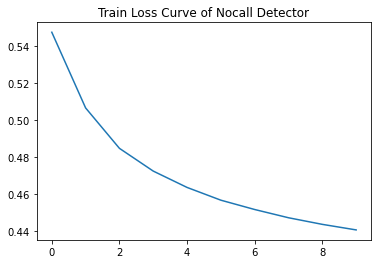

In [15]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Nocall Detector')

C:\Users\youngrae\AppData\Local\Temp/ipykernel_7404/4126914523.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_losses = torch.tensor(val_losses, device = 'cpu')


Text(0.5, 1.0, 'Validation Accuracy Curve of Nocall Detector')

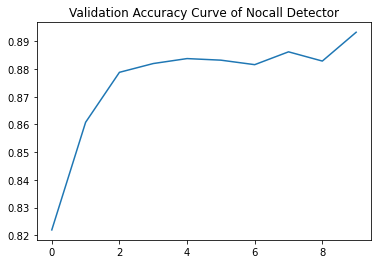

In [16]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Nocall Detector')

C:\Users\youngrae\AppData\Local\Temp/ipykernel_7404/1290367574.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_scores = torch.tensor(log_scores, device = 'cpu')


Text(0.5, 1.0, 'Log-score Curve of Nocall Detector')

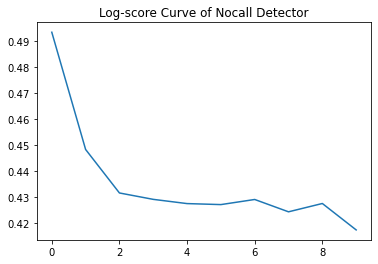

In [17]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Nocall Detector')

C:\Users\youngrae\AppData\Local\Temp/ipykernel_7404/3035292173.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')


Text(0.5, 1.0, 'F-beta score Curve of Nocall Detector')

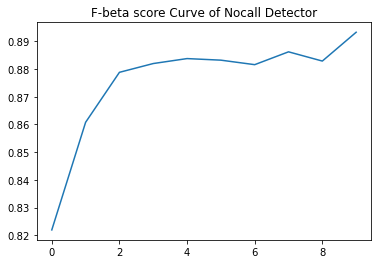

In [18]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Nocall Detector')

In [19]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 88.25
Log Loss score:	0.43
Fbeta-score (beta=1.0): 	0.88
